In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Mors as mors
import scipy.integrate as integrate
from math import nan
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.colors as mcolors

'''masses = np.arange(0.3,1.0,0.1)

#saving new stars, only run this cell once
for i,mass in enumerate(masses):
    star = mors.Star(Mstar = mass, percentile=50)
    star.Save(filename = 'p50_m'+str(round(mass,1))+'.pickle')
    

for i,mass in enumerate(masses):
    star = mors.Star(Mstar = mass, percentile=10)
    star.Save(filename = 'p10_m'+str(round(mass,1))+'.pickle')

for i,mass in enumerate(masses):
    star = mors.Star(Mstar = mass, percentile=90.0)
    star.Save(filename = 'p90_m'+str(round(mass,1))+'.pickle')
'''
Dont run this again!!!

star = mors.Star(Mstar = 1.0, percentile=10)
star.Save(filename = 'p10_m'+str(1)+'.pickle')

star = mors.Star(Mstar = 1.0, percentile=50)
star.Save(filename = 'p50_m'+str(1)+'.pickle')

star = mors.Star(Mstar = 1.0, percentile=90)
star.Save(filename = 'p90_m'+str(1)+'.pickle')
#don't run this again!!!

In [ ]:
#Plot the Lx curves for different speeds and masses
#Similar to what I did in the previous notebook, plot how evaporation time changes with mass
#Also put all the fast %mass curves together, 50ths with 50ths etc

In [2]:
def LxTrack(mass):
    #efficiency between 0-1
    #M_pl in fraction of earth
    #R_pl in fraction of earth


    #need flux over course of time for each case of rotator
    p10 = mors.Load('rp10/p10_m'+str(mass)+'.pickle')
    p50 = mors.Load('rp50/p50_m'+str(mass)+'.pickle')
    p90 = mors.Load('rp90/p90_m'+str(mass)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)

    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Lx')
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Lx')
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Lx')

    
    '''
    plt.plot(t,p10_Lx)
    plt.plot(t,p50_Lx)
    plt.plot(t,p90_Lx)
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Lx Tracks for mass='+str(mass))
    plt.xlabel('Age (10Myr-5Gyr)')
    plt.ylabel('Lx (erg s-1)')
    plt.figure()'''
    return p10_Lx,p50_Lx,p90_Lx

In [3]:
def findHZ(M_star,age):
    '''
    M_star in solar masses
    age in Myr
    '''
    
    HZbounds = np.empty((len(age),2))
    
    for i,t in enumerate(age):
        HZbounds[i]=(np.array([mors.aOrbHZ(Mstar=M_star,Age=t)['RecentVenus'],mors.aOrbHZ(Mstar=M_star, Age=t)['EarlyMars']]))

    #initial overlap is just the first HZ range
    overlap = HZbounds[0]
    
    for i,array in enumerate(HZbounds[1:]):
        if max(overlap[0], array[0]) <= min(overlap[1], array[1]):
            overlap = np.array((max(overlap[0], array[0]), min(overlap[1], array[1])))
    return overlap

In [4]:
def massLossRate(efficiency, M_pl, R_pl, M_star,chz,returnMasses=False):
    #efficiency between 0-1
    #M_pl in fraction of earth
    #R_pl in fraction of earth

    #need to get M_pl in actual mass
    Mp = M_pl * 5.97E24 #kg


    #same for R_pl
    Rp = R_pl * 6.37E6 #m

    #need flux over course of time for each case of rotator
    p10 = mors.Load('rp10/p10_m'+str(M_star)+'.pickle')
    p50 = mors.Load('rp50/p50_m'+str(M_star)+'.pickle')
    p90 = mors.Load('rp90/p90_m'+str(M_star)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)


    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    p10_Leuv = np.empty(len(t))
    p50_Leuv = np.empty(len(t))
    p90_Leuv = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Lx')
        p10_Leuv[i] = p10.Value(Age = age, Quantity='Leuv')
        
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Lx')
        p50_Leuv[i] = p50.Value(Age = age, Quantity='Leuv')
        
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Lx')
        p90_Leuv[i] = p90.Value(Age = age, Quantity='Leuv')

    
    #F=L/4pir^2
    #need to find the orbital distance within the CHZ using findHZ
    r = chz * 1.496E13
    
    p10_flux = (p10_Lx + p10_Leuv)/(4 * np.pi * r**2)
    p50_flux = (p50_Lx + p50_Leuv)/(4 * np.pi * r**2)
    p90_flux = (p90_Lx + p90_Leuv)/(4 * np.pi * r**2)
    
    #need radius of atmosphere
    R_atm = Rp*1.1 #meters

    #gravitational constant
    G = 6.67E-11 #si
    
    
    M_atm = 5E-3*Mp
    Mdot10 = np.pi*efficiency*p10_flux*R_atm**2*Rp/(G*Mp)   
    Mdot50 = np.pi*efficiency*p50_flux*R_atm**2*Rp/(G*Mp)  
    Mdot90 = np.pi*efficiency*p90_flux*R_atm**2*Rp/(G*Mp)
    
    
    #put Mdot in kg/year
    Mdot10_kg = Mdot10*1E-3*3.15E7
    Mdot50_kg = Mdot50*1E-3*3.15E7
    Mdot90_kg = Mdot90*1E-3*3.15E7
   
    M10 = (M_atm - integrate.cumtrapz(y=Mdot10_kg, x=t*1e6)) / M_atm *100
    M50 = (M_atm - integrate.cumtrapz(y=Mdot50_kg, x=t*1e6)) / M_atm *100
    M90 = (M_atm - integrate.cumtrapz(y=Mdot90_kg, x=t*1e6)) / M_atm *100

    if returnMasses:
        return M10,M50,M90
    else:
        plt.plot(t[1:],M10,color='green')
        plt.plot(t[1:],M50)
        plt.plot(t[1:],M90)
        plt.yscale('log')
        plt.xscale('log')
        plt.ylim([1,1E2])
        plt.title('%mass remaining over time m='+str(mass))
        plt.xlabel('Age (10Myr-5Gyr)')
        plt.ylabel('% mass')
    
    if len(t[np.where(M10<=1)]) != 0:
        return t[np.where(M10 <= 1)][0], t[np.where(M50 <= 1)][0], t[np.where(M90 <= 1)][0]
    elif len(t[np.where(M50 <= 1)]) != 0:
        return nan,t[np.where(M50 <= 1)][0], t[np.where(M90 <= 1)][0]
    elif len(t[np.where(M90 <= 1)]) != 0:
        return nan,nan, t[np.where(M90 <= 1)][0]
    else:
        return nan,nan,nan

columns = ['Mass','CHZ','AAL(10th)','AAL(50th)','AAL(90th)'] #AAL - Age at atmosphere lost
all_data = pd.DataFrame(columns=columns)
all_data['Mass'] = [round(mass,1) for mass in np.arange(0.3,1.1,0.1)]
all_data['CHZ'] = [np.mean(findHZ(round(mass,1),age=np.linspace(10,5000,50))) for mass in all_data['Mass']]
for i,mass in enumerate(all_data['Mass']):
    ages = massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i])
    all_data['AAL(10th)'][i] = ages[0]
    all_data['AAL(50th)'][i] = ages[1]
    all_data['AAL(90th)'][i] = ages[2]
all_data.to_csv('RefinedCHZ_data.csv')

In [5]:
all_data=pd.read_csv('RefinedCHZ_data.csv')

In [6]:
all_data['Mass'][4]

0.7

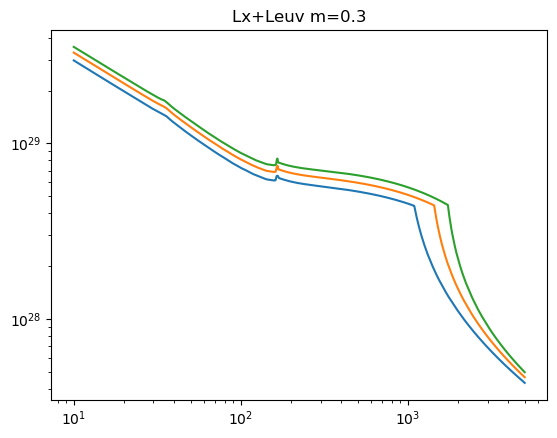

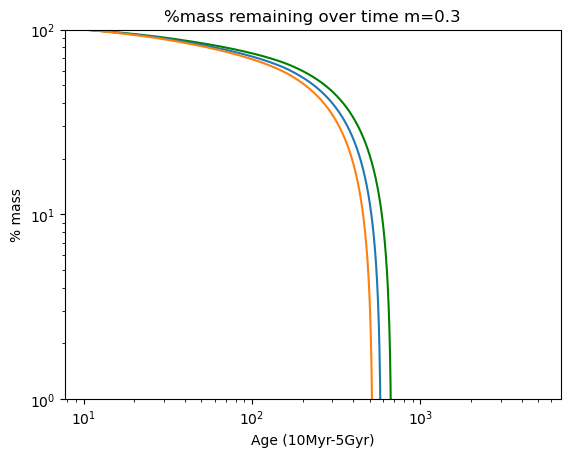

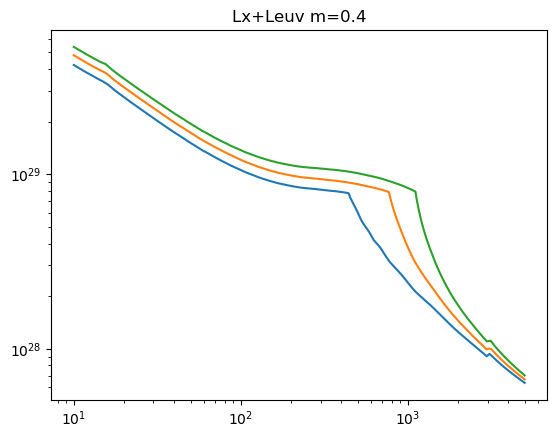

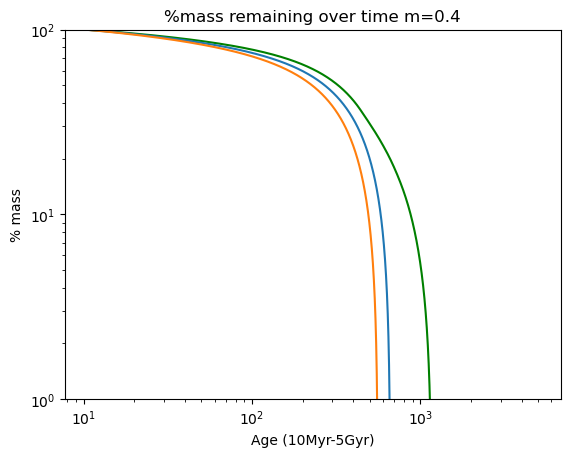

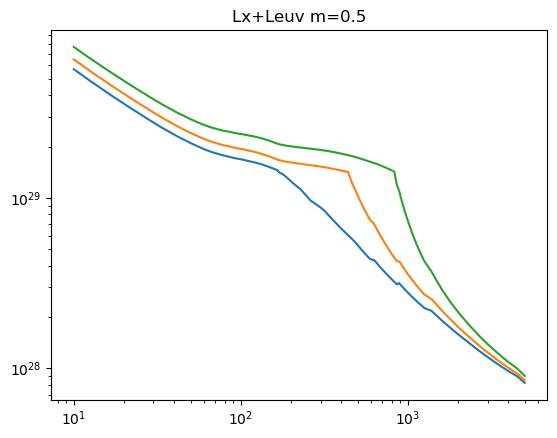

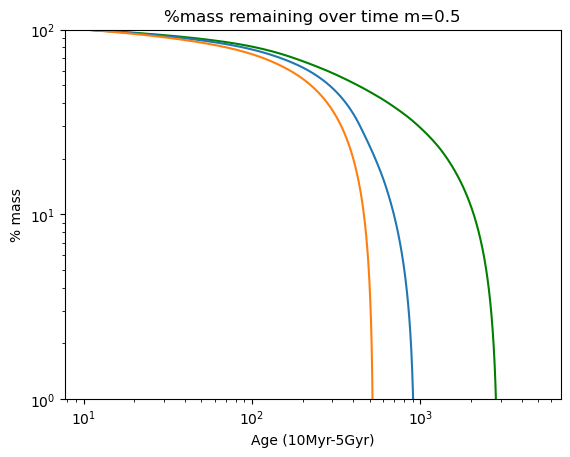

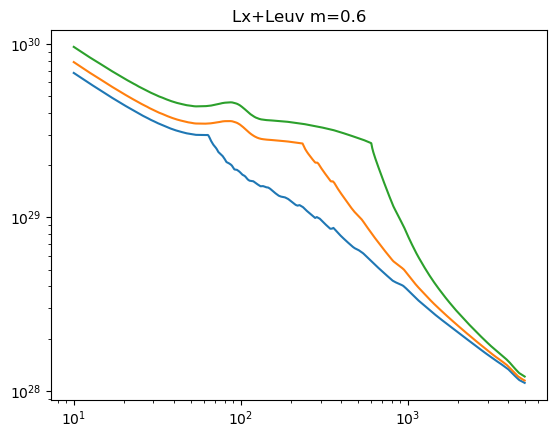

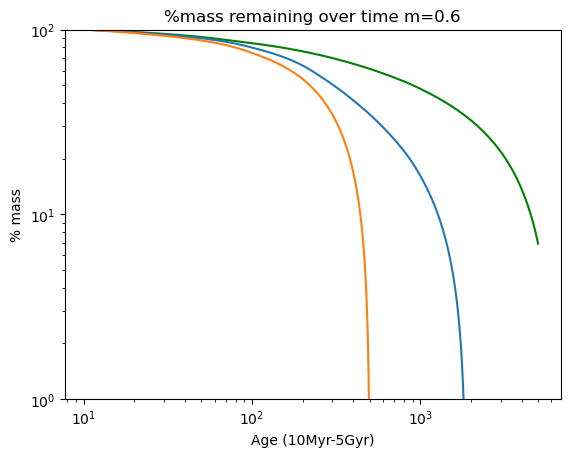

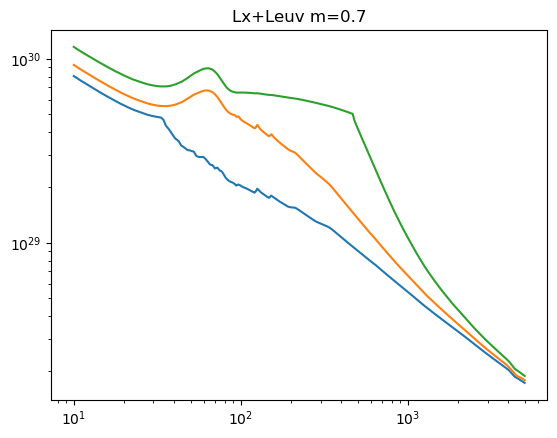

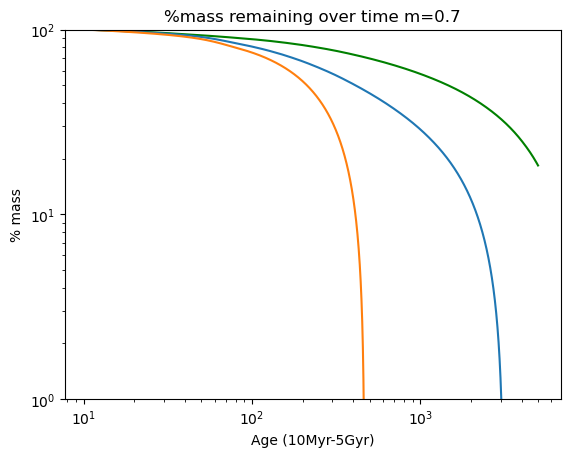

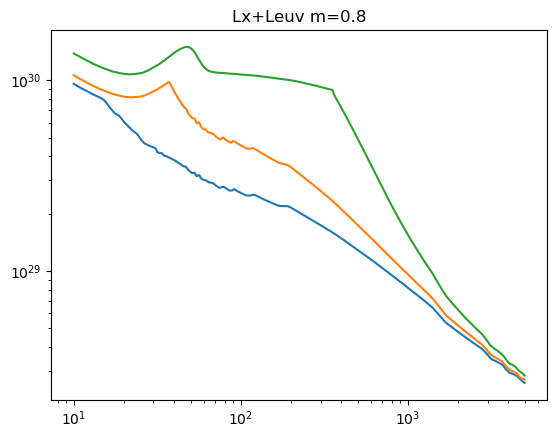

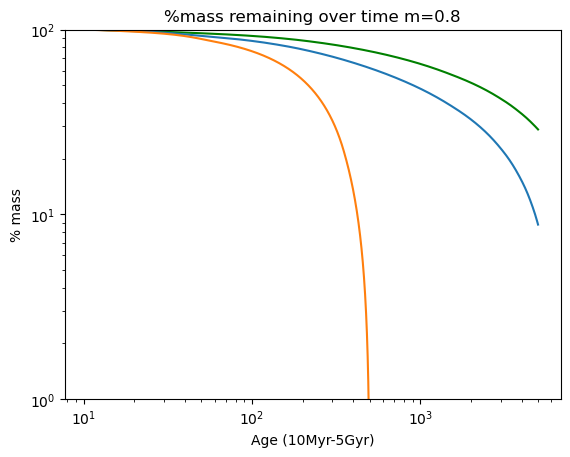

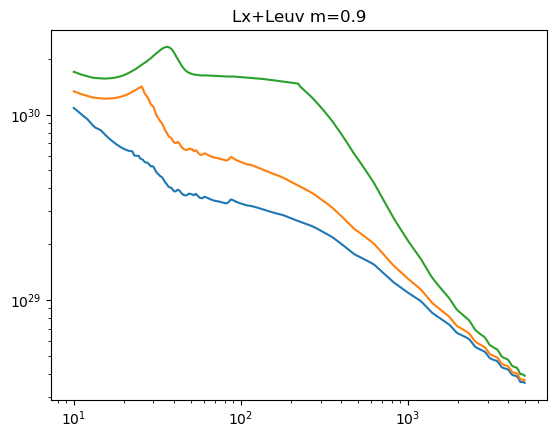

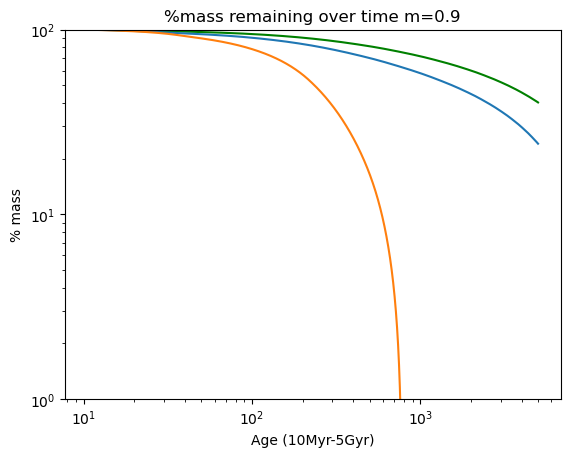

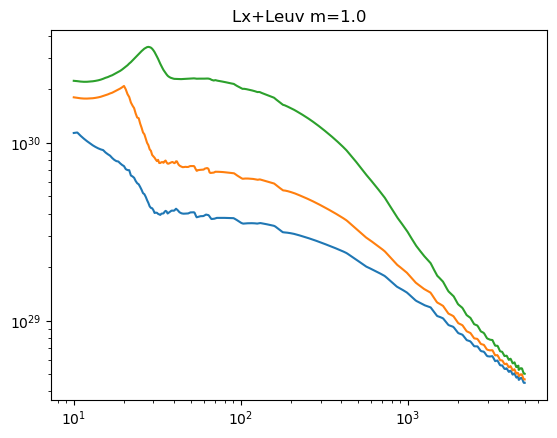

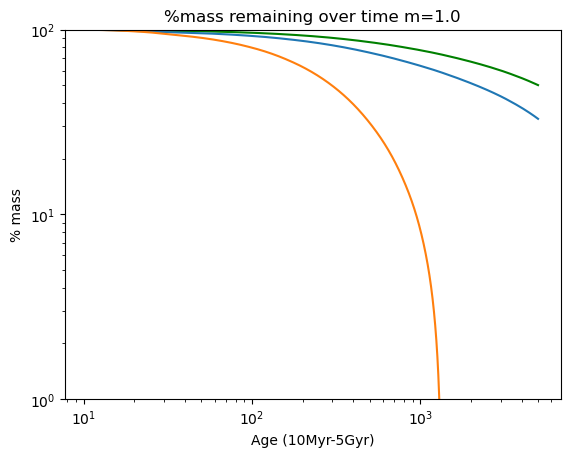

<Figure size 640x480 with 0 Axes>

In [9]:
t = np.linspace(10,5000,10000)
for i,mass in enumerate(all_data['Mass']):
    plt.title('Lx+Leuv m='+str(mass))
    plt.plot(t,LeuvTrack(mass)[0]+LxTrack(mass)[0])
    plt.plot(t,LeuvTrack(mass)[1]+LxTrack(mass)[1])
    plt.plot(t,LeuvTrack(mass)[2]+LxTrack(mass)[2])
    plt.xscale('log')
    plt.yscale('log')
    plt.figure()
    massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i])
    plt.figure()

In [37]:
massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i],returnMasses=True)


(array([99.94638622, 99.89374886, 99.84318575, ..., 50.02664057,
        50.02454326, 50.02244591]),
 array([99.9154555 , 99.83145055, 99.74781629, ..., 32.87514307,
        32.87295079, 32.87075851]),
 array([ 99.89514159,  99.79079996,  99.68690351, ..., -31.03074233,
        -31.03310094, -31.03545949]))

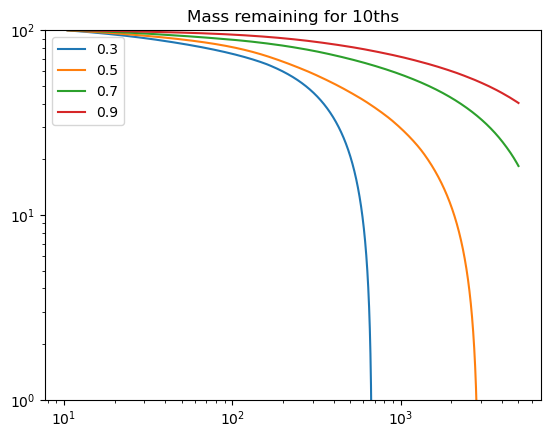

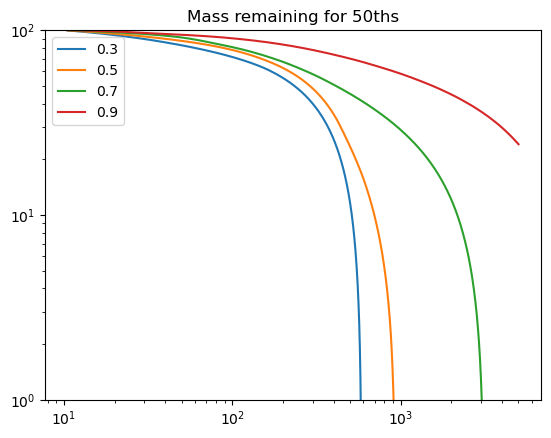

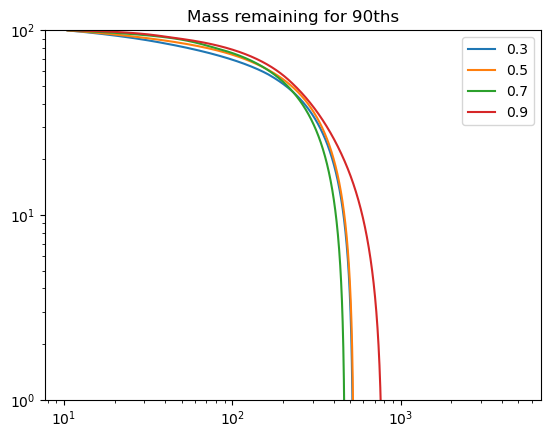

In [141]:
#plot the same speeds together, just using 0.3,0.5,0.7,0.9
t=np.linspace(10,5000,10000)

for i,mass in enumerate(all_data['Mass']):
    if i%2 == 0:
        plt.title('Mass remaining for 10ths')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([1,100])
        plt.plot(t[1:],massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i],returnMasses=True)[0],label=f'{mass}')
plt.legend()
plt.figure()

for i,mass in enumerate(all_data['Mass']):
    if i%2 == 0:
        plt.title('Mass remaining for 50ths')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([1,100])
        plt.plot(t[1:],massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i],returnMasses=True)[1],label=f'{mass}')
plt.legend()
plt.figure()
for i,mass in enumerate(all_data['Mass']):
    if i%2 == 0:
        plt.title('Mass remaining for 90ths')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([1,100])
        plt.plot(t[1:],massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i],returnMasses=True)[2],label=f'{mass}')

plt.legend()

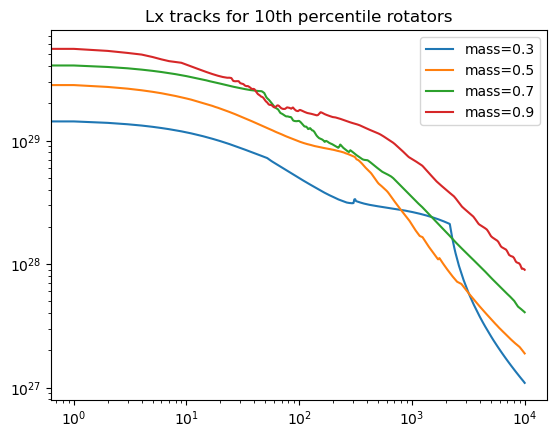

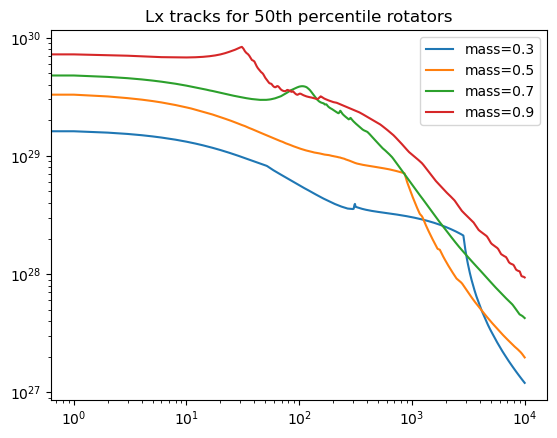

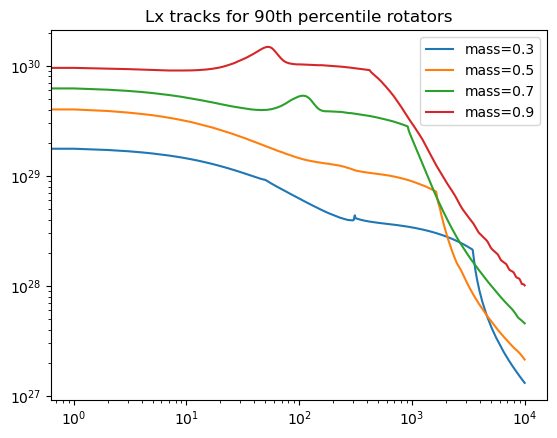

In [16]:
#now plot all of the luminosity curves same speeds together
masses = [0.3,0.5,0.7,0.9]
for mass in masses:
    plt.plot(LxTrack(mass)[0],label=f'mass={mass}')
plt.title('Lx tracks for 10th percentile rotators')
plt.xlabel('')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in masses:
    plt.plot(LxTrack(mass)[1],label=f'mass={mass}')
plt.title('Lx tracks for 50th percentile rotators')
plt.legend()

plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in masses:
    plt.plot(LxTrack(mass)[2],label=f'mass={mass}')
plt.title('Lx tracks for 90th percentile rotators')
plt.legend()

In [8]:
#Now do Leuv tracks
def LeuvTrack(mass):

    #need flux over course of time for each case of rotator
    p10 = mors.Load('rp10/p10_m'+str(mass)+'.pickle')
    p50 = mors.Load('rp50/p50_m'+str(mass)+'.pickle')
    p90 = mors.Load('rp90/p90_m'+str(mass)+'.pickle')

    #need age range
    t = np.linspace(10,5000,10000)

    p10_Lx = np.empty(len(t))
    p50_Lx = np.empty(len(t))
    p90_Lx = np.empty(len(t))
    
    for i,age in enumerate(t):
        p10_Lx[i] = p10.Value(Age = age, Quantity='Leuv')
        p50_Lx[i] = p50.Value(Age = age, Quantity = 'Leuv')
        p90_Lx[i] = p90.Value(Age = age, Quantity = 'Leuv')

    return p10_Lx,p50_Lx,p90_Lx

Text(0, 0.5, 'Leuv')

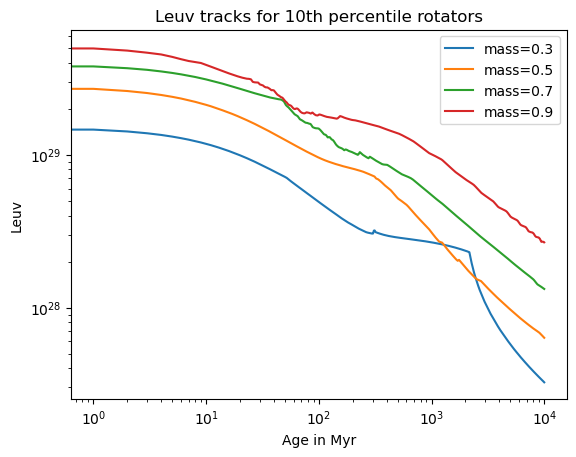

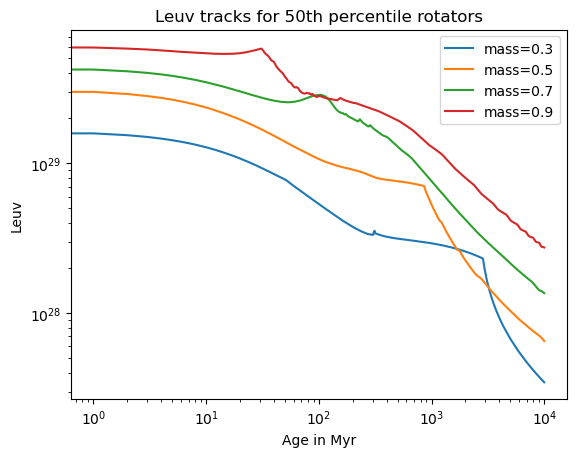

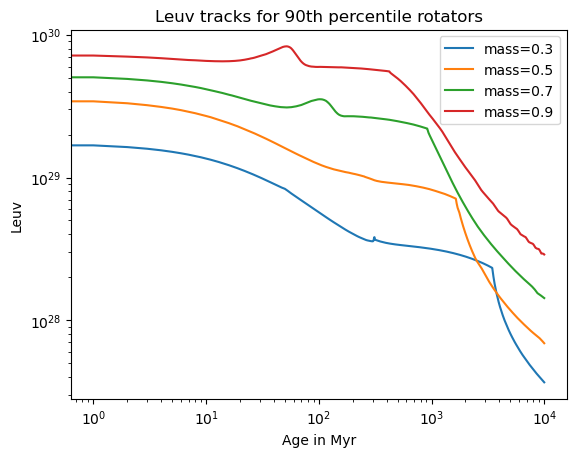

In [29]:
masses = [0.3,0.5,0.7,0.9]
for mass in masses:
    plt.plot(LeuvTrack(mass)[0],label=f'mass={mass}')
plt.title('Leuv tracks for 10th percentile rotators')
plt.xlabel('Age in Myr')
plt.ylabel('Leuv')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in masses:
    plt.plot(LeuvTrack(mass)[1],label=f'mass={mass}')
plt.title('Leuv tracks for 50th percentile rotators')
plt.legend()
plt.xlabel('Age in Myr')
plt.ylabel('Leuv')

plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in masses:
    plt.plot(LeuvTrack(mass)[2],label=f'mass={mass}')
plt.title('Leuv tracks for 90th percentile rotators')
plt.legend()
plt.xlabel('Age in Myr')
plt.ylabel('Leuv')

Text(0, 0.5, 'Leuv+Lx')

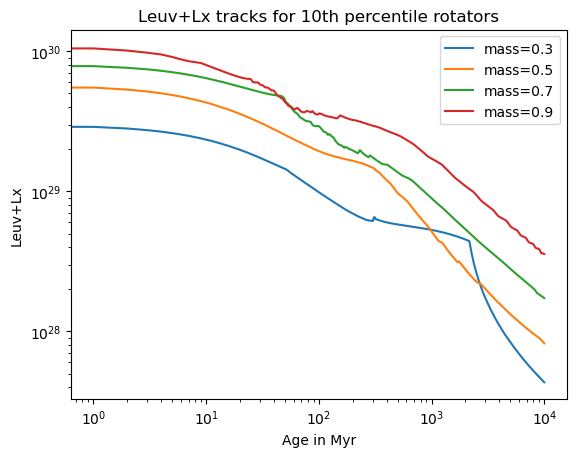

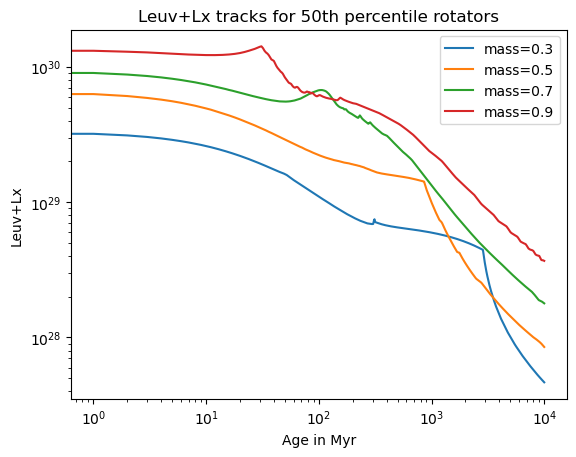

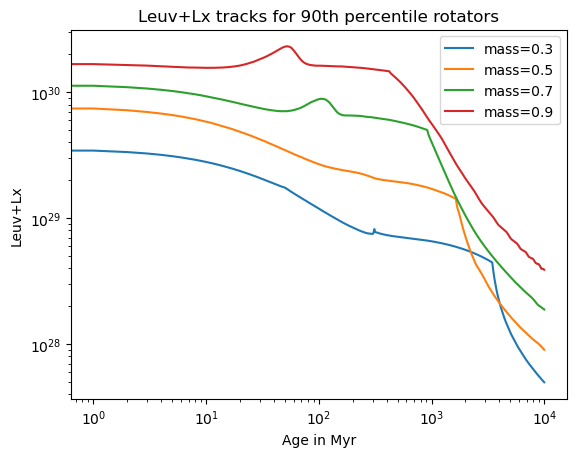

In [19]:
#now plot the sum of the Leuv and Lx tracks
masses = [0.3,0.5,0.7,0.9]
for mass in masses:
    plt.plot(LeuvTrack(mass)[0]+LxTrack(mass)[0],label=f'mass={mass}')
plt.title('Leuv+Lx tracks for 10th percentile rotators')
plt.xlabel('Age in Myr')
plt.ylabel('Leuv+Lx')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in masses:
    plt.plot(LeuvTrack(mass)[1]+LxTrack(mass)[1],label=f'mass={mass}')
plt.title('Leuv+Lx tracks for 50th percentile rotators')
plt.legend()
plt.xlabel('Age in Myr')
plt.ylabel('Leuv+Lx')

plt.figure()
plt.xscale('log')
plt.yscale('log')
for mass in masses:
    plt.plot(LeuvTrack(mass)[2]+LxTrack(mass)[2],label=f'mass={mass}')
plt.title('Leuv+Lx tracks for 90th percentile rotators')
plt.legend()
plt.xlabel('Age in Myr')
plt.ylabel('Leuv+Lx')

Text(0.5, 1.0, 'Age at ~total loss as function of mass, separated by rotation speed')

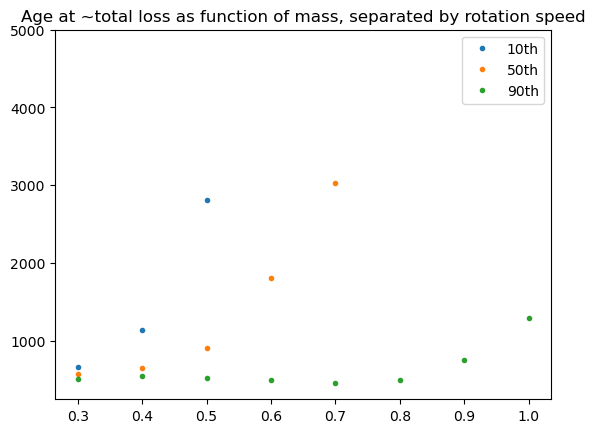

In [52]:
#now make the same plot I made in moreEnergyApprox of the age at ~total loss
t=np.linspace(10,5000,10000)
plt.plot(all_data['Mass'],all_data['AAL(10th)'],'.',label='10th')
plt.plot(all_data['Mass'],all_data['AAL(50th)'],'.',label='50th')
plt.plot(all_data['Mass'],all_data['AAL(90th)'],'.',label='90th')
plt.legend()
plt.ylim(250,5000)
plt.title('Age at ~total loss as function of mass, separated by rotation speed')
#could probably fit some lines to this, but the same plot with more masses

In [64]:
len(massLossRate(0.3,0.5,1,0.3,all_data['CHZ'][i],returnMasses=True)[0])

9999

In [143]:
all_data['CHZ'],all_data['Mass']

(0    0.219896
 1    0.279070
 2    0.352312
 3    0.445238
 4    0.559635
 5    0.708713
 6    0.894240
 7    1.086491
 Name: CHZ, dtype: float64,
 0    0.3
 1    0.4
 2    0.5
 3    0.6
 4    0.7
 5    0.8
 6    0.9
 7    1.0
 Name: Mass, dtype: float64)

In [139]:
t[1316]

666.7496749674967

In [ ]:
for i,value in enumerate(massLossRate(0.3,0.5,1,0.3,all_data['CHZ'][0],returnMasses=True)[0]):
    if value < 1:
        print(i)

In [148]:
remaining_atm_mass_10 = [massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i],returnMasses=True)[0] for i,mass in enumerate(all_data['Mass'])]
remaining_atm_mass_10 = np.array(remaining_atm_mass_10)
remaining_atm_mass_10[remaining_atm_mass_10 < 0] = 1e-10


remaining_atm_mass_50 = [massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i],returnMasses=True)[1] for i,mass in enumerate(all_data['Mass'])]
remaining_atm_mass_50 = np.array(remaining_atm_mass_50)
remaining_atm_mass_50[remaining_atm_mass_50 < 0] = 1e-10


remaining_atm_mass_90 = [massLossRate(0.3,0.5,1,mass,all_data['CHZ'][i],returnMasses=True)[2] for i,mass in enumerate(all_data['Mass'])]
remaining_atm_mass_90 = np.array(remaining_atm_mass_90)
remaining_atm_mass_90[remaining_atm_mass_90 < 0] = 1e-10


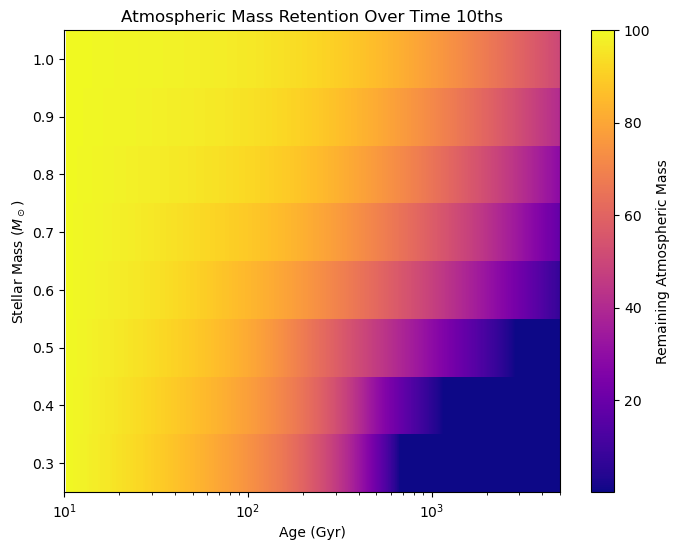

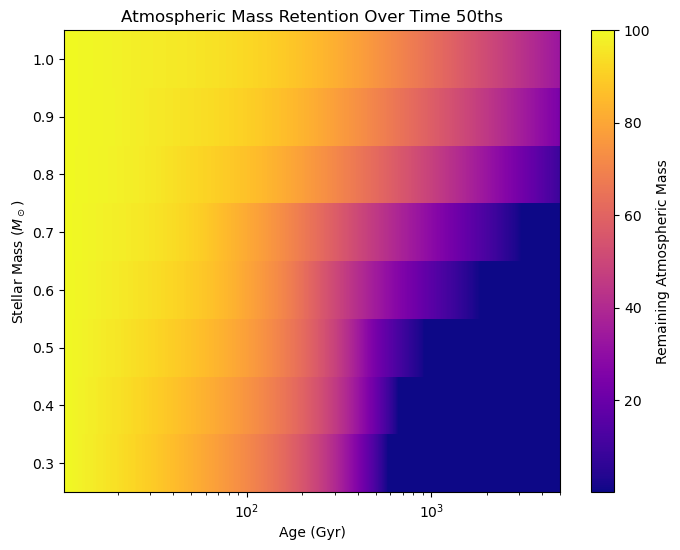

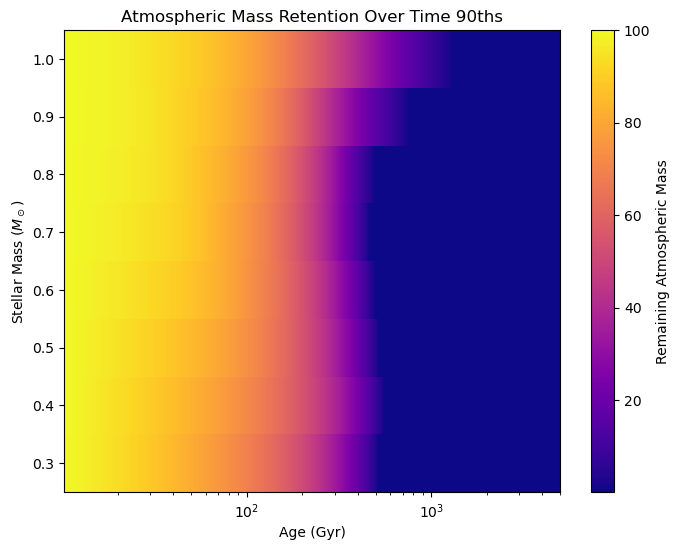

In [152]:
#colorful plot time

plt.figure(figsize=(8, 6))
plt.pcolormesh(t[1:], all_data['Mass'], remaining_atm_mass_10, shading='auto', cmap='plasma',vmin=1e-1, vmax=100)
plt.colorbar(label='Remaining Atmospheric Mass')
plt.xlabel("Age (Gyr)")
plt.ylabel("Stellar Mass ($M_\\odot$)")
plt.title("Atmospheric Mass Retention Over Time 10ths")
plt.xscale('log')
plt.xlim(10,5000)
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(t[1:], all_data['Mass'], remaining_atm_mass_50, shading='auto', cmap='plasma',vmin=1e-1, vmax=100)
plt.colorbar(label='Remaining Atmospheric Mass')
plt.xlabel("Age (Gyr)")
plt.ylabel("Stellar Mass ($M_\\odot$)")
plt.title("Atmospheric Mass Retention Over Time 50ths")
plt.xscale('log')
plt.show()

plt.figure(figsize=(8, 6))
plt.pcolormesh(t[1:], all_data['Mass'], remaining_atm_mass_90, shading='auto', cmap='plasma',vmin=1e-1, vmax=100)
plt.colorbar(label='Remaining Atmospheric Mass')
plt.xlabel("Age (Gyr)")
plt.ylabel("Stellar Mass ($M_\\odot$)")
plt.title("Atmospheric Mass Retention Over Time 90ths")
plt.xscale('log')
plt.show()


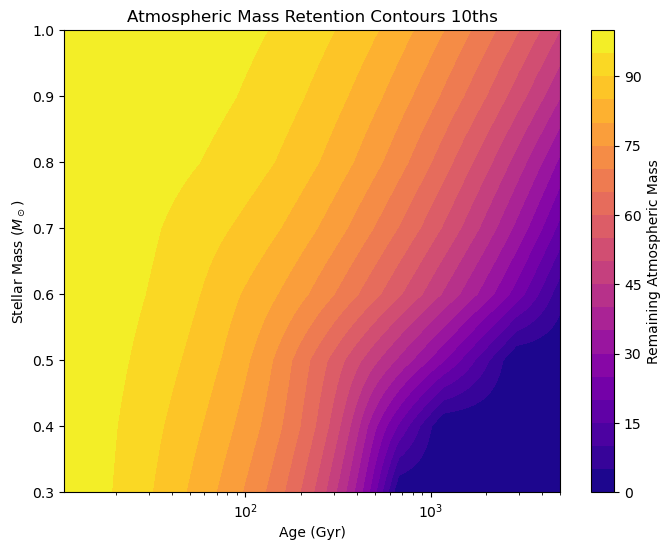

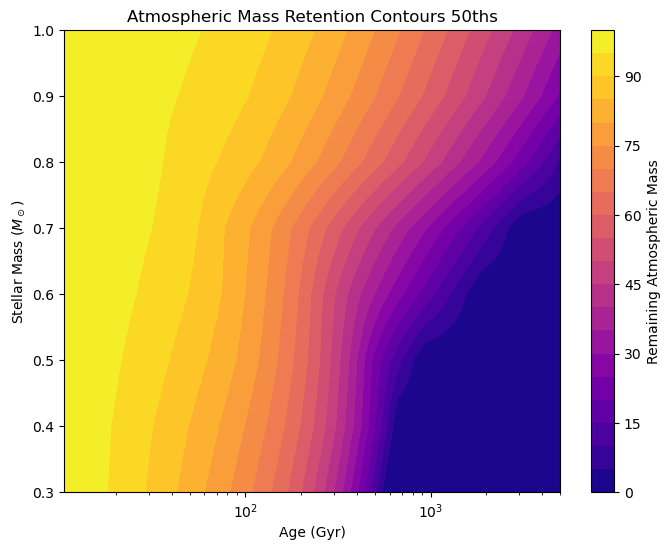

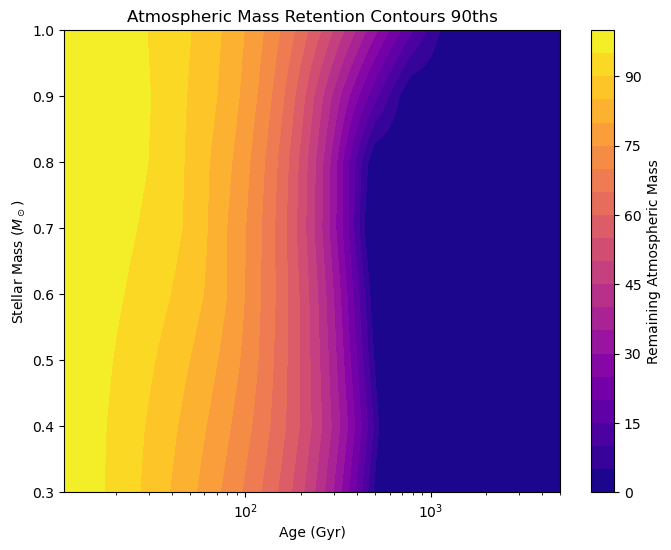

In [155]:
plt.figure(figsize=(8,6))
plt.contourf(t[1:], all_data['Mass'], remaining_atm_mass_10, levels=20, cmap='plasma')
plt.colorbar(label='Remaining Atmospheric Mass')
plt.xlabel("Age (Gyr)")
plt.ylabel("Stellar Mass ($M_\\odot$)")
plt.title("Atmospheric Mass Retention Contours 10ths")
plt.xscale('log')
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(t[1:], all_data['Mass'], remaining_atm_mass_50, levels=20, cmap='plasma')
plt.colorbar(label='Remaining Atmospheric Mass')
plt.xlabel("Age (Gyr)")
plt.ylabel("Stellar Mass ($M_\\odot$)")
plt.title("Atmospheric Mass Retention Contours 50ths")
plt.xscale('log')
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(t[1:], all_data['Mass'], remaining_atm_mass_90, levels=20, cmap='plasma')
plt.colorbar(label='Remaining Atmospheric Mass')
plt.xlabel("Age (Gyr)")
plt.ylabel("Stellar Mass ($M_\\odot$)")
plt.title("Atmospheric Mass Retention Contours 90ths")
plt.xscale('log')
plt.show()

In [5]:
d = {}
for x in range(1, 10):
    d["string{0}".format(x)] = "Hello"
d

{'string1': 'Hello',
 'string2': 'Hello',
 'string3': 'Hello',
 'string4': 'Hello',
 'string5': 'Hello',
 'string6': 'Hello',
 'string7': 'Hello',
 'string8': 'Hello',
 'string9': 'Hello'}